In [146]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

## Load all the data

All the CSVs should be available in the data directory. We will not modify these.

Output will be written to the output dir.

In [80]:
DATADIR = Path("../data")
INPUT_DATADIR = Path(DATADIR / "readonly")
OUTPUT_DATADIR = Path(DATADIR / "output")

# Read pd dataframes for files in data/readonly
dwa_reference = pd.read_csv(INPUT_DATADIR / "dwa_reference.csv")
task_statements = pd.read_csv(INPUT_DATADIR / "task_statements.csv")
tasks_to_dwas = pd.read_csv(INPUT_DATADIR / "tasks_to_dwas.csv")
occupation_data = pd.read_csv(INPUT_DATADIR / "occupation_data.csv")
bls_onet = pd.read_csv(INPUT_DATADIR / "bls_onet.csv")
bls_matrix = pd.read_csv(INPUT_DATADIR / "bls_matrix.csv")
industry_output = pd.read_csv(INPUT_DATADIR / "industry_output.csv")

## Alpha Beta Zeta functions.

Alpha is normalized count of class 1.

Beta is normalized count of class 1 + 0.5 * (class 2 or 3)

Zeta is normalized count of class 1 or 2 or 3.

In [81]:
# Define functions to calculate alpha, beta, and zeta for a single group
def calculate_alpha(group):
    return (group['classification'] == 1).sum() / len(group)

def calculate_beta(group):
    return ((group['classification'] == 1).sum() + 0.5 * (group['classification'].isin([2, 3]).sum())) / len(group)

def calculate_zeta(group):
    return (group['classification'].isin([1, 2, 3])).sum() / len(group)

## Calculate exposure values for tasks.

1. `dwa_reference` -> `tasks_to_dwas`
2. Group `tasks_to_dwas` by `task_id` while calculating alpha beta and zeta.
3. Merge back to `task_statements` by `task_id`

In [82]:

# Step 1: Join to get classifications
merged_df = tasks_to_dwas.merge(dwa_reference, on='dwa_id', how='left')

# Step 2: Group by 'task_id' and calculate alpha, beta, and zeta
grouped_df = merged_df.groupby('task_id').apply(lambda x: pd.Series({
    'alpha': calculate_alpha(x),
    'beta': calculate_beta(x),
    'zeta': calculate_zeta(x)
})).reset_index()

# Step 3: Merge back to task_statements
task_statements_updated = task_statements.merge(grouped_df, on='task_id', how='left').fillna(0)

## Calculate occupations based on Tasks

1. Merge `task_statements_updated` and `occupation_data` on `onetsoc_code`
2. Group by `occupation_title` and calculate alpha beta and zeta with a simple mean.
3. Merge back with `occupation_data` to create `occupation_data_updated`.

In [83]:
# Step 1: Merge task_statements_updated with occupation_data to get onetsoc_code in the same DataFrame
merged_with_occupation = task_statements_updated.merge(occupation_data, on='onetsoc_code', how='right')

# Step 2: Group by 'onetsoc_code' and average the alpha, beta, zeta values
grouped_by_occupation = merged_with_occupation.groupby('onetsoc_code').agg({
    'alpha': 'mean',
    'beta': 'mean',
    'zeta': 'mean'
}).reset_index()

# Step 3: Merge these averaged values back into the original occupation_data DataFrame
occupation_data_updated = occupation_data.merge(grouped_by_occupation, on='onetsoc_code', how='left').fillna(0)

## Calculate `bls_matrix` from `occupation_data`

Results in alpha, beta, zeta scores for each industry.

In [89]:
# Assuming we have dataframes: bls_matrix_original, bls_onet, occupation_data_updated
# Note: These are placeholders; you'd use your actual dataframes in your code.

# Step 1: Drop rows where occupation_type = "Summary"
bls_matrix_filtered = bls_matrix[bls_matrix['occupation_type'] != 'Summary'].copy()

# Step 2: Map occupation_code (nem_code) to onetsoc_code using bls_onet
bls_matrix_merged = bls_matrix_filtered.merge(bls_onet, left_on='occupation_code', right_on='nem_code', how='left')

# Step 3: Drop rows where onetsoc_code is NaN
bls_matrix_cleaned = bls_matrix_merged.dropna(subset=['onetsoc_code']).copy()

# Step 4: Merge the alpha, beta, zeta scores from occupation_data_updated
bls_matrix_with_scores = bls_matrix_cleaned.merge(
    occupation_data_updated[['onetsoc_code', 'alpha', 'beta', 'zeta']], 
    on='onetsoc_code', 
    how='left'
).copy()

# Step 5: Calculate the weighted alpha, beta, zeta for each industry
industry_exposure_updated = bls_matrix_with_scores.groupby('industry_code').apply(lambda x: pd.Series({
    'alpha': (x['alpha'] * x['employment_2022']).sum() / x['employment_2022'].sum(),
    'beta': (x['beta'] * x['employment_2022']).sum() / x['employment_2022'].sum(),
    'zeta': (x['zeta'] * x['employment_2022']).sum() / x['employment_2022'].sum(),
    'industry_title': x['industry_title'].iloc[0],
    'employment_2022': x['employment_2022'].sum()    
})).reset_index()

# Now, you can run this block as many times as you want without altering the original dataframes.
# The results will be stored in new dataframes: bls_matrix_filtered, bls_matrix_merged, bls_matrix_cleaned, bls_matrix_with_scores, industry_exposure_updated
industry_exposure_updated['delta'] = industry_exposure_updated['zeta'] - industry_exposure_updated['alpha']

# Note: The original dataframes (bls_matrix_original, bls_onet, occupation_data_updated) remain unchanged.

In [110]:
# Revert the fill_values function to only take in a row, assuming that it will be used in a DataFrame.apply() context
# where industry_exposure_updated is implicitly accessible.

def fill_values(row):
    naics = row[' 2022 NAICS']
    
    # Initialize the values
    alpha, beta, zeta = 0.0, 0.0, 0.0
    
    # Handling multiple patterns
    industry_codes = []
    
    if pd.isna(naics) or naics == 'NA':
        return pd.Series([0.0, 0.0, 0.0])

    # If it's a range like '31-33'
    if '-' in naics:
        start, end = map(int, naics.split('-'))
        range_values = [str(i) for i in range(start, end + 1)]
        industry_codes.extend(range_values)
    
    # If it's comma-separated like '21,22'
    if ',' in naics:
        industry_codes.extend(naics.split(','))
    
    # If it's a single number
    if not industry_codes:
        industry_codes.append(naics)
    
    # Fetching corresponding exposure metrics
    subset_df = industry_exposure_updated[industry_exposure_updated['industry_code'].str.startswith(tuple(industry_codes))]
    alpha = subset_df['alpha'].mean()
    beta = subset_df['beta'].mean()
    zeta = subset_df['zeta'].mean()
    
    return pd.Series([alpha, beta, zeta])

# Calculate alpha, beta, zeta for industry_output
industry_output[['alpha', 'beta', 'zeta']] = industry_output.apply(fill_values, axis=1)
industry_output['delta'] = industry_output['zeta'] - industry_output['alpha']



## Clean data

Output sometimes has values like 1,329.4. Stripping commas to convert to float.

In [148]:
# Cleaning up the DataFrame by dropping NaN or 'NA' in '2022 NAICS'
industry_output_clean = industry_output.dropna(subset=[' 2022 NAICS'])
industry_output_clean = industry_output_clean[industry_output_clean[' 2022 NAICS'] != 'NA']

# Convert employment and output columns to float for graphing
for col in ['Employment, 2022', 'Output, 2022']:
    industry_output_clean[col] = industry_output_clean[col].str.replace(',', '').astype(float)

## Calculate output scaled exposures

In [150]:
industry_output_clean['Output-Alpha_Exposure'] = industry_output_clean['Output, 2022'] * industry_output_clean['alpha']
industry_output_clean['Output-Beta_Exposure'] = industry_output_clean['Output, 2022'] * industry_output_clean['beta']
industry_output_clean['Output-Zeta_Exposure'] = industry_output_clean['Output, 2022'] * industry_output_clean['zeta']
industry_output_clean['Output-Delta_Exposure'] = industry_output_clean['Output, 2022'] * industry_output_clean['delta']

# industry_output_clean

## Save the CSVs

In [145]:
industry_output.to_csv(OUTPUT_DATADIR / "industry_output.csv", index=False)
industry_output_clean.to_csv(OUTPUT_DATADIR / "industry_output_clean.csv", index=False)

## Analysis section

In [151]:
n = 20

# Top 5 Industries by Alpha Score
top_alpha = industry_output_clean.nlargest(n, 'alpha')

# Top 5 Industries by Delta Score
top_delta = industry_output_clean.nlargest(n, 'delta')

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

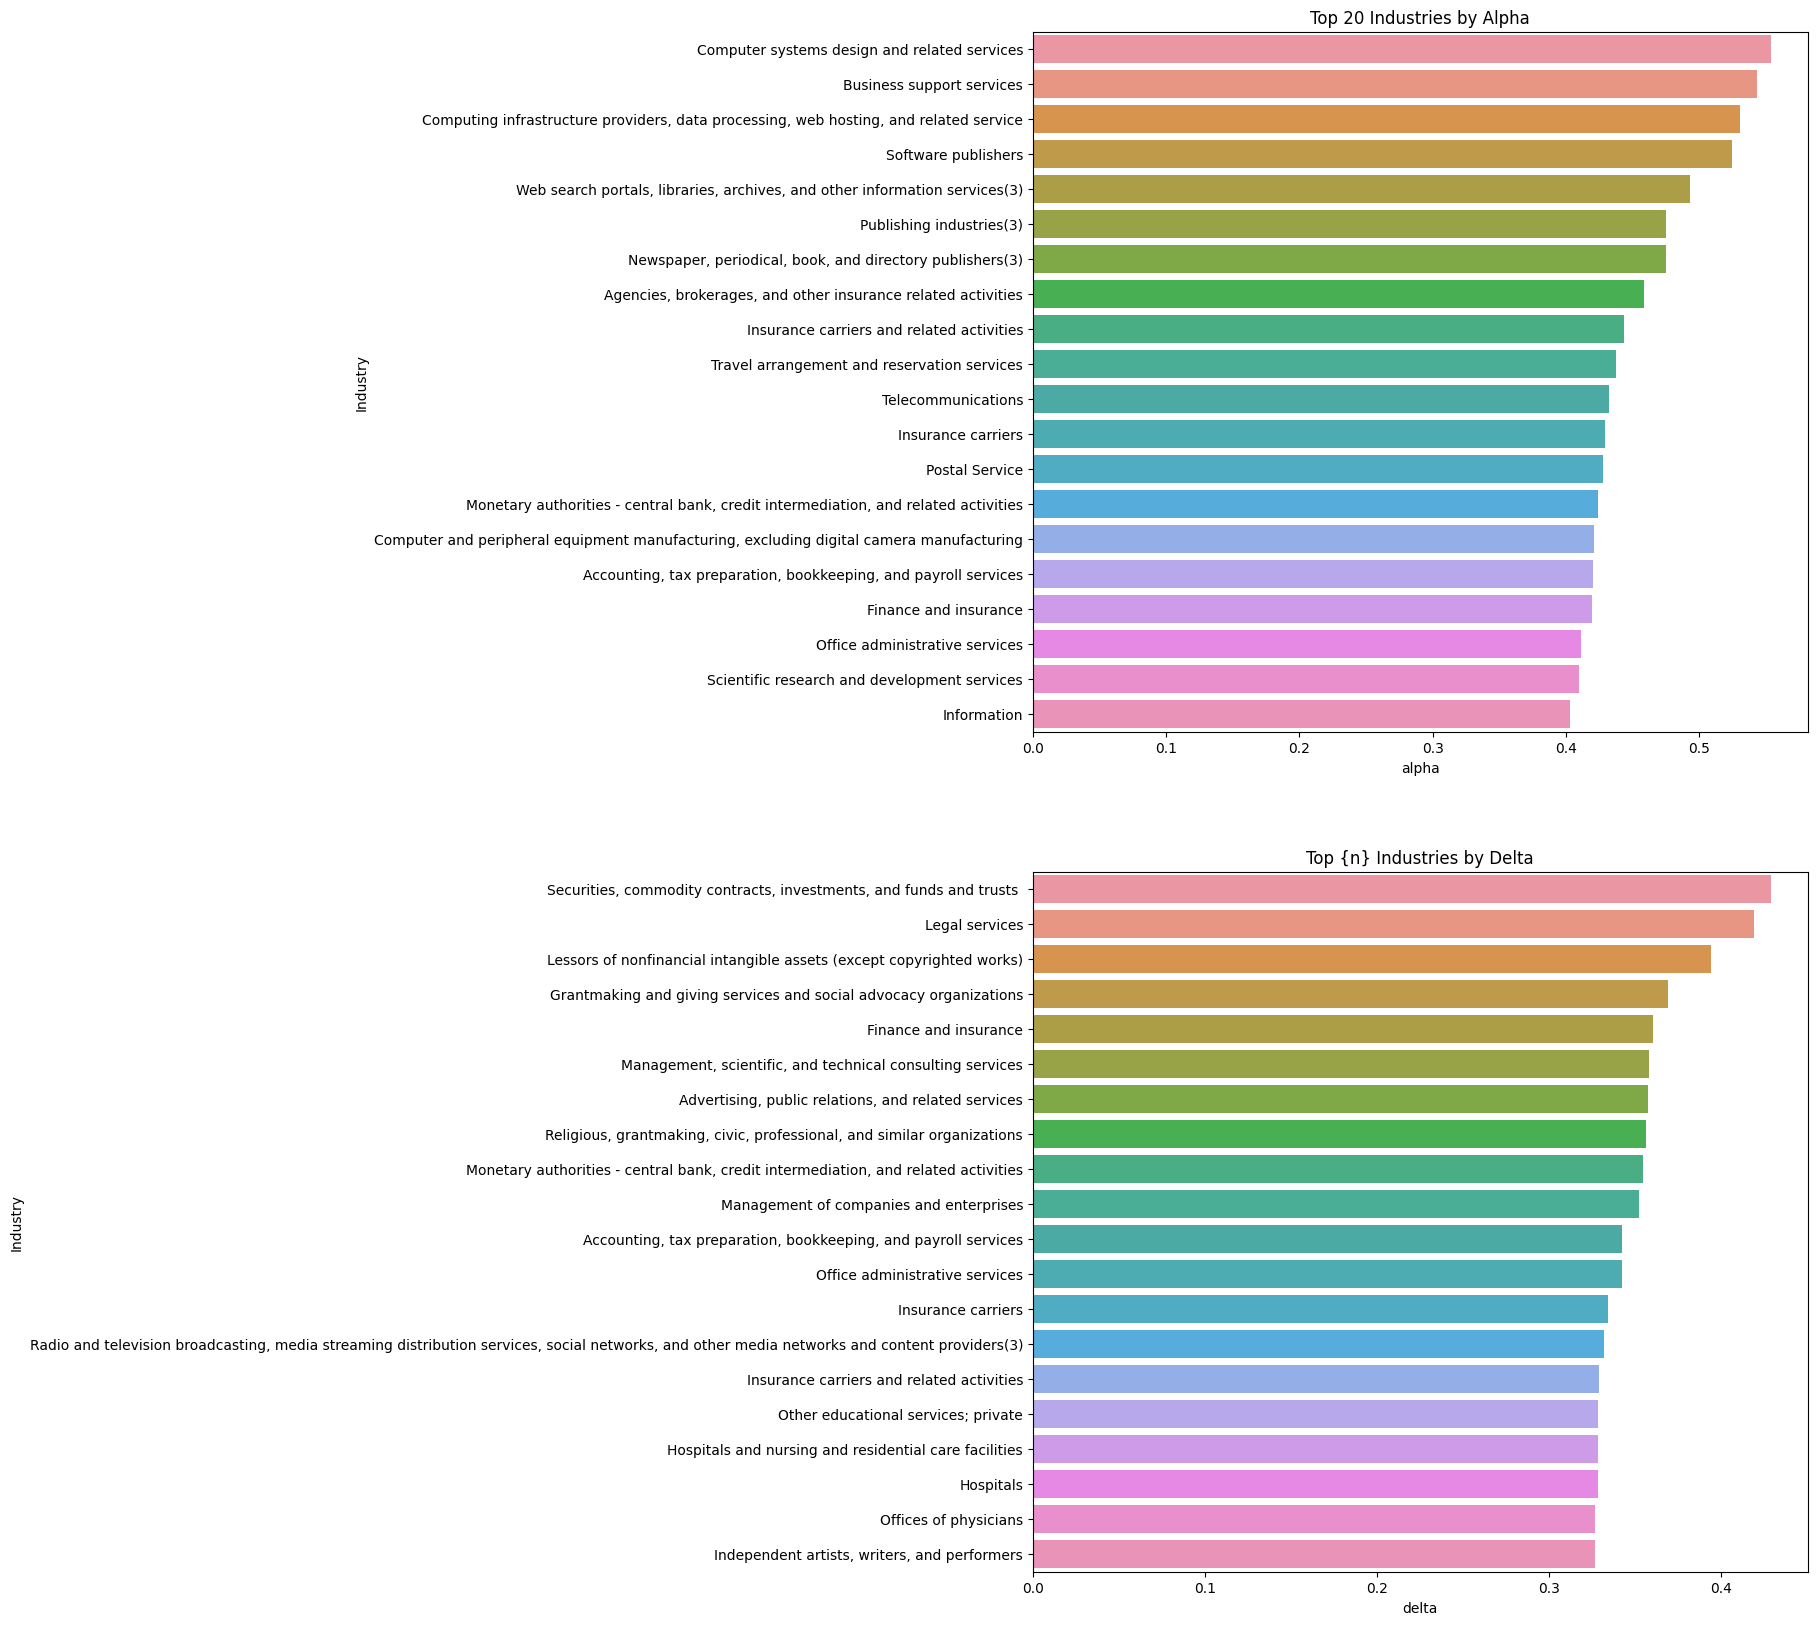

In [153]:
# Let's plot these insights with 5 charts stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(10, 20))

sns.barplot(x='alpha', y='Industry', data=top_alpha, ax=axes[0])
axes[0].set_title(f'Top {n} Industries by Alpha')

sns.barplot(x='delta', y='Industry', data=top_delta, ax=axes[1])
axes[1].set_title('Top {n} Industries by Delta')

plt.tight_layout()
plt.show()


/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetr

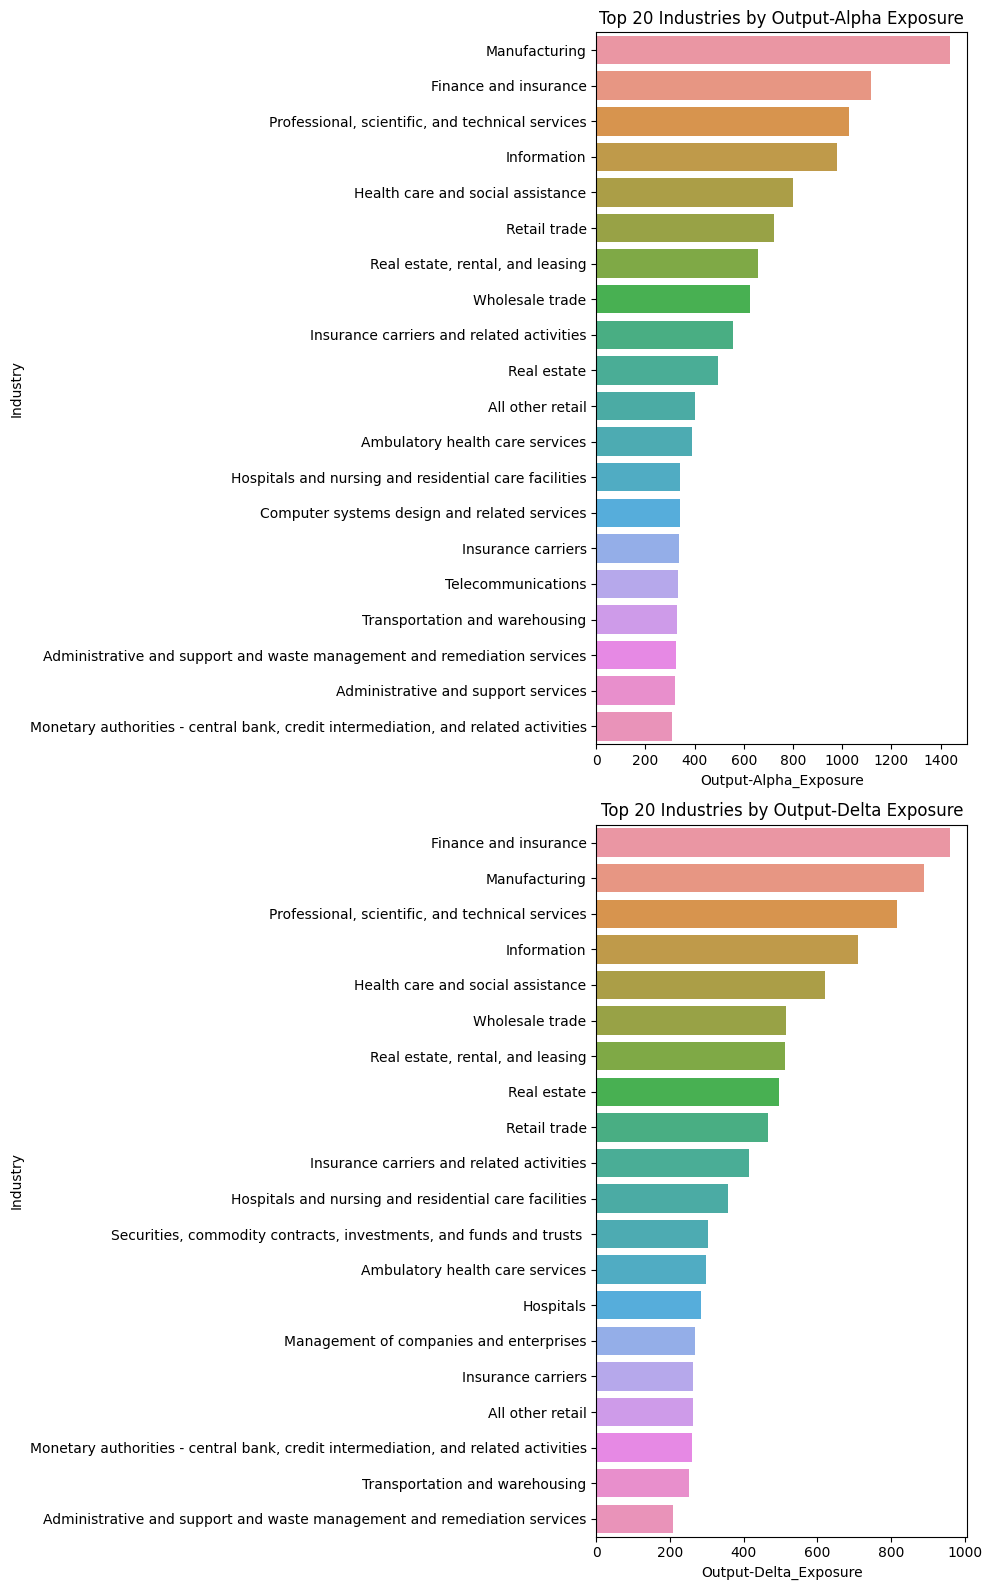

In [154]:
# Top 20 Industries by Combined Output-Alpha Exposure
top_output_alpha = industry_output_clean.nlargest(n, 'Output-Alpha_Exposure')

# Top 20 Industries by Combined Output-Delta Exposure
top_output_delta = industry_output_clean.nlargest(n, 'Output-Delta_Exposure')

# Let's plot these insights
fig, axes = plt.subplots(2, 1, figsize=(10, 16))

sns.barplot(x='Output-Alpha_Exposure', y='Industry', data=top_output_alpha, ax=axes[0])
axes[0].set_title(f'Top {n} Industries by Output-Alpha Exposure')

sns.barplot(x='Output-Delta_Exposure', y='Industry', data=top_output_delta, ax=axes[1])
axes[1].set_title(f'Top {n} Industries by Output-Delta Exposure')

plt.tight_layout()
plt.show()

/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rushabh/Library/Caches/pypoetry/virtualenvs/gptsaregpts-bRn197-3-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


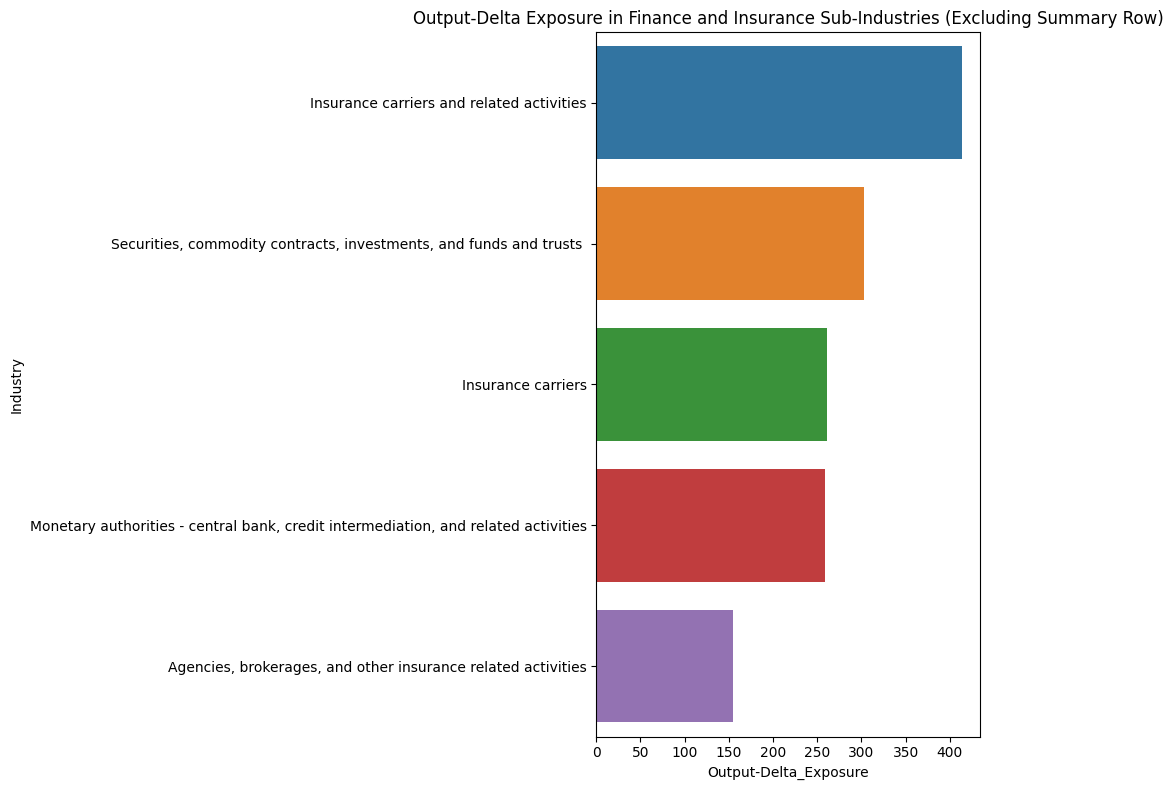

In [155]:
# Filter out Finance and Insurance industries (NAICS code starts with 52)
finance_industries_filtered = industry_output_clean[
    industry_output_clean[' 2022 NAICS'].str.startswith('52') & 
    (industry_output_clean[' 2022 NAICS'] != '52')
]

# Sort by Output-Delta Exposure again
finance_industries_sorted = finance_industries_filtered.sort_values(by='Output-Delta_Exposure', ascending=False)

# Plotting Output-Delta Exposure for Finance and Insurance sub-industries without the summary row
plt.figure(figsize=(10, 8))
sns.barplot(x='Output-Delta_Exposure', y='Industry', data=finance_industries_sorted)
plt.title('Output-Delta Exposure in Finance and Insurance Sub-Industries (Excluding Summary Row)')
plt.tight_layout()
plt.show()
